# Нейронная сеть на Keras и оптимизация гиперпараметров

## 1 Импорт библиотек, инициализация глобальных констант

### 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from colorama import Fore, Back, Style

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import keras_tuner

### 1.2 Инициализация констант

In [2]:
# путь к папке с данными
path = Path('/kaggle/input/mckinsey-imputed')
# название целевой переменной
TARGET_NAME = 'Approved'
# количество фолдов для кросс-валидации
N_FOLDS = 5
# random state для воспроизводимости
RANDOM_STATE = 42
# размер отложенной выборки
TEST_SIZE = 0.2
# размер батча
BATCH_SIZE = 1024
# количество эпох
EPOCHS = 100
# количество комбинаций гиперпараметров
MAX_TRIALS = 100
# директория для сохранения результатов при оптимизации
OUTPUT_DIR = '/kaggle/temp'

In [3]:
# фиксируем random state для воспроизводимости
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

## 2 Подготовка данных

In [4]:
train = pd.read_csv(path / 'train_imputed.csv')
test = pd.read_csv(path / 'test_imputed.csv')
train

,ID,Gender,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,Customer_Existing_Primary_Bank_Code,Primary_Bank_Type,...,Credit_over_income,Credit_pct_over_income,Monthly_Income_in_city,Monthly_Income_at_employer,Monthly_Income_in_source_category,Monthly_Income_over_city_income,Monthly_Income_over_employeer_income,Monthly_Income_over_category_income,Loan_Amount_is_null,Age
0,APPC90493171225,Female,C10001,A,another,A,4.0,2000.0,B001,P,...,0.000000,0.000000,13461.737114,2000.000000,4517.348356,0.148569,1.000000,0.442738,1,36
1,APPD40611263344,Male,C10003,A,COM0000002,C,1.0,3500.0,B002,P,...,2.857143,0.378571,4130.332287,4789.257987,4517.348356,0.847389,0.730802,0.774791,0,29
2,APPE70289249423,Male,another,C,another,C,4.0,2250.0,B003,G,...,5.000000,0.000000,3668.495833,2250.000000,6218.750490,0.613330,1.000000,0.361809,0,33
3,APPF80273865537,Male,another,C,another,A,4.0,3500.0,B003,G,...,5.257143,0.000000,1525.000000,2700.000000,6218.750490,2.295082,1.296296,0.562814,0,27
4,APPG60994436641,Male,C10002,A,another,A,4.0,10000.0,B001,P,...,2.500000,0.000000,4465.358272,6644.750000,6218.750490,2.239462,1.504948,1.608040,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69708,APPU90955789628,Female,C10006,A,COM0000010,A,1.0,4900.0,B002,P,...,0.000000,0.000000,4042.877278,5781.724828,4517.348356,1.212008,0.847498,1.084707,1,33
69709,APPV80989824738,Female,another,C,another,A,4.0,7190.1,B002,P,...,0.000000,0.000000,4886.480000,7190.100000,4517.348356,1.471427,1.000000,1.591664,1,45
69710,APPW50697209842,Female,C10022,B,another,C,4.0,1600.0,B030,P,...,3.750000,1.331250,3472.887186,1625.000000,4517.348356,0.460712,0.984615,0.354190,0,24
69711,APPY50870035036,Male,C10002,A,another,C,3.0,9893.0,B002,P,...,1.617305,0.000000,4465.358272,3265.884615,4517.348356,2.215500,3.029195,2.190002,0,38


### 2.1 Используемые признаки при обучении

In [5]:
# используемые признаки при обучении
features = [
    c for c in train.columns if c != 'ID' and c != 'Approved'
    and c != 'Monthly_Income_in_source_category'
]
# численные признаки
num_features = train.select_dtypes(
    include=[int, float]).nunique()[lambda x: x > 25].index
# категориальные признаки
cat_features = list(set(features) - set(num_features))

# признаки, которые нужно логарифмировать
to_log = [
    'Monthly_Income', 'Existing_EMI', 'Loan_Amount', 'EMI',
    'Loan_Amount_per_Period', 'Credit_pct', 'Credit_pct_per_Period',
    'Amount_plus_pct', 'Amount_plus_pct_per_period',
    'Amount_plus_pct_over_amount', 'Credit_over_income',
    'Monthly_Income_in_city', 'Monthly_Income_at_employer',
    'Monthly_Income_over_city_income', 'Monthly_Income_over_employeer_income',
    'Monthly_Income_over_category_income'
]

Многие вещественные признаки имеют тяжелые хвосты, прологарифмируем их

In [6]:
for col in to_log:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])

### 2.2 Отложенная выборка

In [7]:
tr_data, te_data = train_test_split(train,
                                    test_size=TEST_SIZE,
                                    random_state=RANDOM_STATE,
                                    stratify=train[TARGET_NAME])
tr_data = tr_data.reset_index(drop=True)
target = te_data[TARGET_NAME]

### 2.3 Предобработка данных

In [8]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'), cat_features),
    ('scaling', StandardScaler(), num_features),
])

n_features = column_transformer.fit_transform(tr_data).shape[1]

## 3 Нейронная сеть

In [9]:
def my_net(hp, n_inputs=n_features):
    
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1)
    activation = hp.Choice('activation',
                           ['relu', 'elu', 'selu', 'tanh', 'swish'])
    num_dense = hp.Int('num_dense', min_value=1, max_value=4, step=1)
    reg = hp.Float("reg", min_value=1e-8, max_value=1e-2)

    inputs = Input(shape=(n_inputs, ))

    for layer in range(num_dense):
        units = hp.Int(f'units_{layer}', min_value=16, max_value=1024, step=16)
        dp = hp.Float(f'dp_{layer}', min_value=0., max_value=0.5)
        if dp == 0:
            if layer == 0:
                x = Dense(units,
                          kernel_regularizer=tf.keras.regularizers.l2(reg),
                          activation=activation)(inputs)
            else:
                x = Dense(units,
                          kernel_regularizer=tf.keras.regularizers.l2(reg),
                          activation=activation)(x)
        else:
            if layer == 0:
                x = Dropout(dp)(inputs)
            else:
                x = Dropout(dp)(x)
            x = Dense(units,
                      kernel_regularizer=tf.keras.regularizers.l2(reg),
                      activation=activation)(x)

    dpfinal = hp.Float('dpfinal', min_value=0., max_value=0.5)
    if dpfinal > 0:
        x = tf.keras.layers.Dropout(dpfinal)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[AUC(name='auc')],
    )
    return model

## 4 Оптимизация гиперпараметров

### 4.1 Вспомогательная функция

In [10]:
def tune_net(train_df, test_df):
    X_train = column_transformer.fit_transform(train_df)
    X_val = column_transformer.transform(test_df)
    y_train = train_df.loc[:, TARGET_NAME].values
    y_val = test_df.loc[:, TARGET_NAME].values

    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc',
                                              patience=3,
                                              factor=0.7,
                                              verbose=1,
                                              mode='max')

    es = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                          patience=6,
                                          verbose=1,
                                          mode='max',
                                          restore_best_weights=True)

    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    tuner = keras_tuner.BayesianOptimization(my_net,
                                             overwrite=True,
                                             objective=keras_tuner.Objective(
                                                 "val_auc", direction="max"),
                                             max_trials=MAX_TRIALS,
                                             directory=OUTPUT_DIR,
                                             seed=RANDOM_STATE)

    tuner.search(X_train,
                 y_train,
                 epochs=1000,
                 validation_data=(X_val, y_val),
                 batch_size=BATCH_SIZE,
                 callbacks=callbacks,
                 verbose=2)

    return tuner

Разбиваем обучающую выборку на тренировочную и валидационную

In [11]:
tr_data_to_tune, te_data_to_tune = train_test_split(
    tr_data,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=tr_data[TARGET_NAME])

### 4.2 Подбор гиперпараметров

In [12]:
tuner = tune_net(tr_data_to_tune, te_data_to_tune)
best_hp = tuner.get_best_hyperparameters(1)[0]

Trial 100 Complete [00h 00m 42s]
val_auc: 0.8276299834251404

Best val_auc So Far: 0.8430749773979187
Total elapsed time: 02h 03m 31s


### 4.3 Результаты

In [13]:
print(f'''
Activation: {best_hp.get('activation')}
Num_dense: {best_hp.get('num_dense')}
Regularization: {best_hp.get('reg')}
learning_rate: {best_hp.get('learning_rate')}
        ''')

for i in range(best_hp.get('num_dense')):
    print(f"Layer {i+1}:")
    print()
    print(f''' 
            Dropout_{i}: {best_hp.get(f'dp_{i}')}
            Units_{i}: {best_hp.get(f'units_{i}')}
            ''')

print(f"Final Dropout: {best_hp.get('dpfinal')}")


Activation: relu
Num_dense: 4
Regularization: 1e-08
learning_rate: 0.0001
        
Layer 1:

 
            Dropout_0: 0.0
            Units_0: 1024
            
Layer 2:

 
            Dropout_1: 0.0
            Units_1: 1024
            
Layer 3:

 
            Dropout_2: 0.5
            Units_2: 16
            
Layer 4:

 
            Dropout_3: 0.5
            Units_3: 1024
            
Final Dropout: 0.5


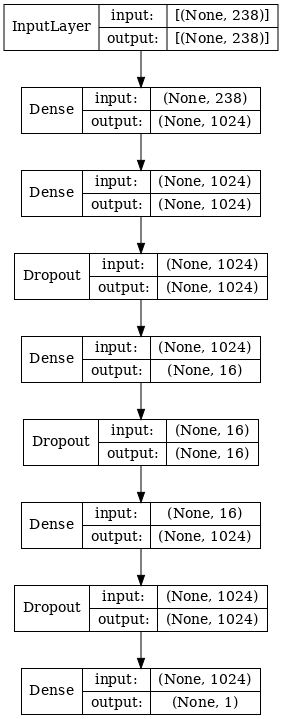

In [14]:
display(
    plot_model(my_net(best_hp),
               show_layer_names=False,
               show_shapes=True,
               dpi=72))

## 5 Обучение модели

In [15]:
score_list = []
histories = []
holdout_pred = np.zeros((len(te_data), 1))
kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_index,
           val_index) in enumerate(kf.split(tr_data, tr_data[TARGET_NAME])):
    
    X_train = tr_data.loc[train_index]
    X_train = column_transformer.fit_transform(X_train)
    X_val = tr_data.loc[val_index]
    X_val = column_transformer.transform(X_val)
    X_test = column_transformer.transform(te_data)
    y_train = tr_data.loc[train_index, TARGET_NAME]
    y_val = tr_data.loc[val_index, TARGET_NAME]

    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc',
                                              patience=3,
                                              factor=0.7,
                                              verbose=1,
                                              mode='max')

    es = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                          patience=6,
                                          verbose=1,
                                          mode='max',
                                          restore_best_weights=True)

    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    model = my_net(best_hp, X_train.shape[1])
    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_val, y_val),
                        epochs=EPOCHS,
                        verbose=1,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)

    histories.append(history)

    preds = model.predict(X_val, batch_size=len(X_val))
    holdout_pred += model.predict(X_test, batch_size=len(X_test))

    score = roc_auc_score(y_val, preds)
    score_list.append(score)

Epoch 1/100
44/44 [==============================] - 5s 85ms/step - loss: 0.3671 - auc: 0.5034 - val_loss: 0.0777 - val_auc: 0.5368
Epoch 2/100
44/44 [==============================] - 3s 79ms/step - loss: 0.0941 - auc: 0.5552 - val_loss: 0.0687 - val_auc: 0.7818
Epoch 3/100
44/44 [==============================] - 3s 78ms/step - loss: 0.0806 - auc: 0.6678 - val_loss: 0.0664 - val_auc: 0.8157
Epoch 4/100
44/44 [==============================] - 3s 78ms/step - loss: 0.0739 - auc: 0.7430 - val_loss: 0.0660 - val_auc: 0.8196
Epoch 5/100
44/44 [==============================] - 3s 79ms/step - loss: 0.0734 - auc: 0.7474 - val_loss: 0.0664 - val_auc: 0.8191
Epoch 6/100
44/44 [==============================] - 4s 87ms/step - loss: 0.0713 - auc: 0.7717 - val_loss: 0.0656 - val_auc: 0.8216
Epoch 7/100
44/44 [==============================] - 3s 75ms/step - loss: 0.0698 - auc: 0.7845 - val_loss: 0.0665 - val_auc: 0.8250
Epoch 8/100
44/44 [==============================] - 3s 77ms/step - loss: 0.

## 6 Результаты

Посмотрим, как менялась ошибка и метрика при обучении

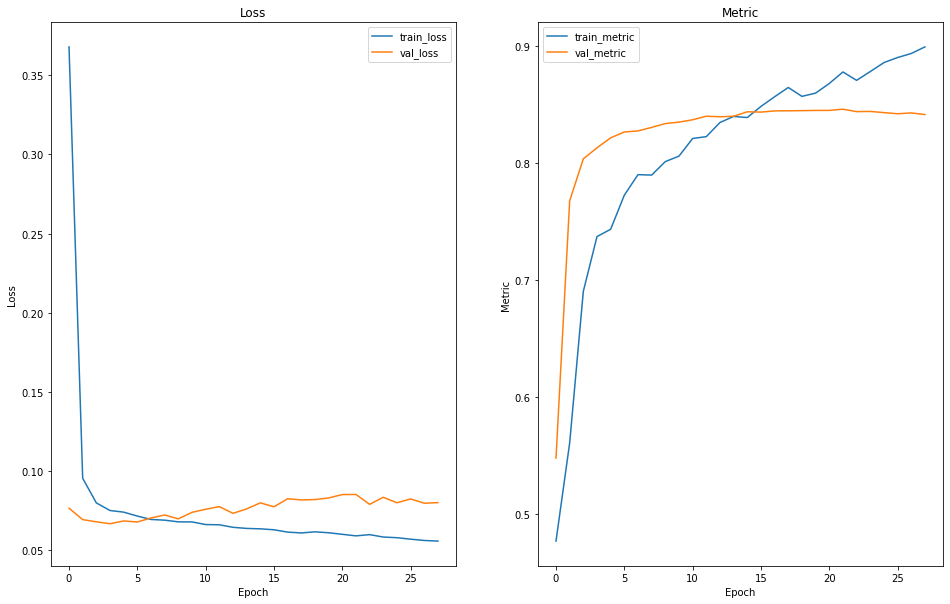

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].plot(histories[2].history['loss'], label='train_loss')
axes[0].plot(histories[2].history['val_loss'], label='val_loss')
axes[1].plot(histories[2].history['auc'], label='train_metric')
axes[1].plot(histories[2].history['val_auc'], label='val_metric')
axes[0].set(title='Loss', ylabel='Loss', xlabel='Epoch')
axes[1].set(title='Metric', ylabel='Metric', xlabel='Epoch')
axes[0].legend()
axes[1].legend()
plt.show()

Качество на кросс-валидации и на отложенной выборке

In [17]:
for fold in range(len(score_list)):
    print(
        f"{Fore.BLACK}{Style.BRIGHT}Fold {fold} ROC-AUC: {score_list[fold]:.5f}"
    )

print(
    f"{Fore.GREEN}{Style.BRIGHT}\nROC-AUC на кросс-валидации: {np.mean(score_list):.5f} +- {np.std(score_list):.5f}"
)
print(
    f"{Fore.RED}ROC-AUC на отложенной выборке: {roc_auc_score(te_data[TARGET_NAME],holdout_pred):.5f}{Style.RESET_ALL}"
)

Fold 0 ROC-AUC: 0.83947
Fold 1 ROC-AUC: 0.85259
Fold 2 ROC-AUC: 0.84513
Fold 3 ROC-AUC: 0.86599
Fold 4 ROC-AUC: 0.85532

ROC-AUC на кросс-валидации: 0.85170 +- 0.00906
ROC-AUC на отложенной выборке: 0.83274
